Mckinsey Insurance hackathon work

We will split this modeling exercise into 3 parts:

    1.) EDA
    
    2.) Part A solution
    
    3.) Part B solution
    

# EDA ( Exploratory Data Analysis) Section

**Summary**: The assigned task for part A is to predict whether a policy will renew given a set of variables. For this analysis, we will be primarily focused on this relationship, but will also delve into any additional relationships and trends that seem noteworthy

In [351]:
# import the packages needed for the overall modeling to take place:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) # set the variables to global
#from Collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# models:

from sklearn.linear_model import LogisticRegression


%matplotlib inline

ModuleNotFoundError: No module named 'Collections'

In [262]:
# read the training data into a pandas dataframe:

df = pd.read_csv('data/train_ZoGVYWq.csv')

### EDA: Data Cleaning

In [263]:
# look at the head of the data:
print(df.head())

       id  perc_premium_paid_by_cash_credit  age_in_days  Income  \
0  110936                             0.429        12058  355060   
1   41492                             0.010        21546  315150   
2   31300                             0.917        17531   84140   
3   19415                             0.049        15341  250510   
4   99379                             0.052        31400  198680   

   Count_3-6_months_late  Count_6-12_months_late  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    2.0                     3.0   
3                    0.0                     0.0   
4                    0.0                     0.0   

   Count_more_than_12_months_late  application_underwriting_score  \
0                             0.0                           99.02   
1                             0.0                           99.89   
2                             1.0                           98.69   
3 

In [264]:
# check the datatypes:

df.dtypes


id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
renewal                               int64
dtype: object

The datatypes appear to be consistent with what we would believe these features would be representative of...

In [265]:
# check the shape of the dataframe to ensure we know how many records we are working with:

df.shape

(79853, 13)

There are nearly 80K records and 13 columns; id cannot be used and that one of those is the target variable. Therefore, there are 11 features in this dataset that can be used in prediction

In [266]:
# check for nulls:

df.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

It looks like there are some null values for some of the cases. Let's see if these should be filtered out (rather than imputed since we have plenty of training data for most algos)

In [267]:
df[df['Count_3-6_months_late'].isnull()].head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
158,73099,1.0,15336,210100,NaN,NaN,NaN,NaN,2,A,Urban,9600,0
1216,81690,1.0,7679,39040,NaN,NaN,NaN,NaN,2,A,Rural,1200,0
1471,49862,1.0,10593,49520,NaN,NaN,NaN,NaN,2,A,Rural,1200,0
3092,59,1.0,17891,90100,NaN,NaN,NaN,NaN,2,A,Urban,5700,1
4177,19184,1.0,18260,40530,NaN,NaN,NaN,NaN,2,A,Rural,1200,0


It does not appear that these columns having null values is dependent on whether the loan is approved or not, if all were the same case, we could replace these values with another in the model so that hte model would recognize the impact of hte extreme amounts. However, we will remove these nulls for the sake of our modeling.

In [268]:
df = df.dropna(axis = 0, how = 'any')
print(df.shape)
df.isnull().sum()



(76855, 13)


id                                  0
perc_premium_paid_by_cash_credit    0
age_in_days                         0
Income                              0
Count_3-6_months_late               0
Count_6-12_months_late              0
Count_more_than_12_months_late      0
application_underwriting_score      0
no_of_premiums_paid                 0
sourcing_channel                    0
residence_area_type                 0
premium                             0
renewal                             0
dtype: int64

While not ideal, we have dropped the nulls from the dataframe

In [269]:
# summarize:

df.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,76855.000000,76855.000000,76855.000000,7.685500e+04,76855.000000,76855.000000,76855.000000,76855.000000,76855.000000,76855.000000,76855.000000
mean,57156.369839,0.314777,18801.935983,2.088393e+05,0.254388,0.076937,0.061154,99.067053,11.054505,11007.937024,0.937805
std,32942.474239,0.330002,5102.226406,3.697466e+05,0.699544,0.430994,0.315304,0.739789,5.106978,9419.183801,0.241511
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28612.500000,0.038000,14975.000000,1.098050e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57241.000000,0.174000,18624.000000,1.683300e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85624.500000,0.534500,22280.000000,2.543950e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37240.000000,5.382190e+07,13.000000,17.000000,11.000000,99.890000,59.000000,60000.000000,1.000000


### EDA: Visualization

In [270]:
# What proportion of the policies actually get renewed?:



df['renewal'].sum() / df['renewal'].count()

0.93780495738728775

In this situation, we are dealing with an unbalanced case, so it is important that we think about that when we are creating any ML models, many models will classify all as being approved, which could  be catastrophic

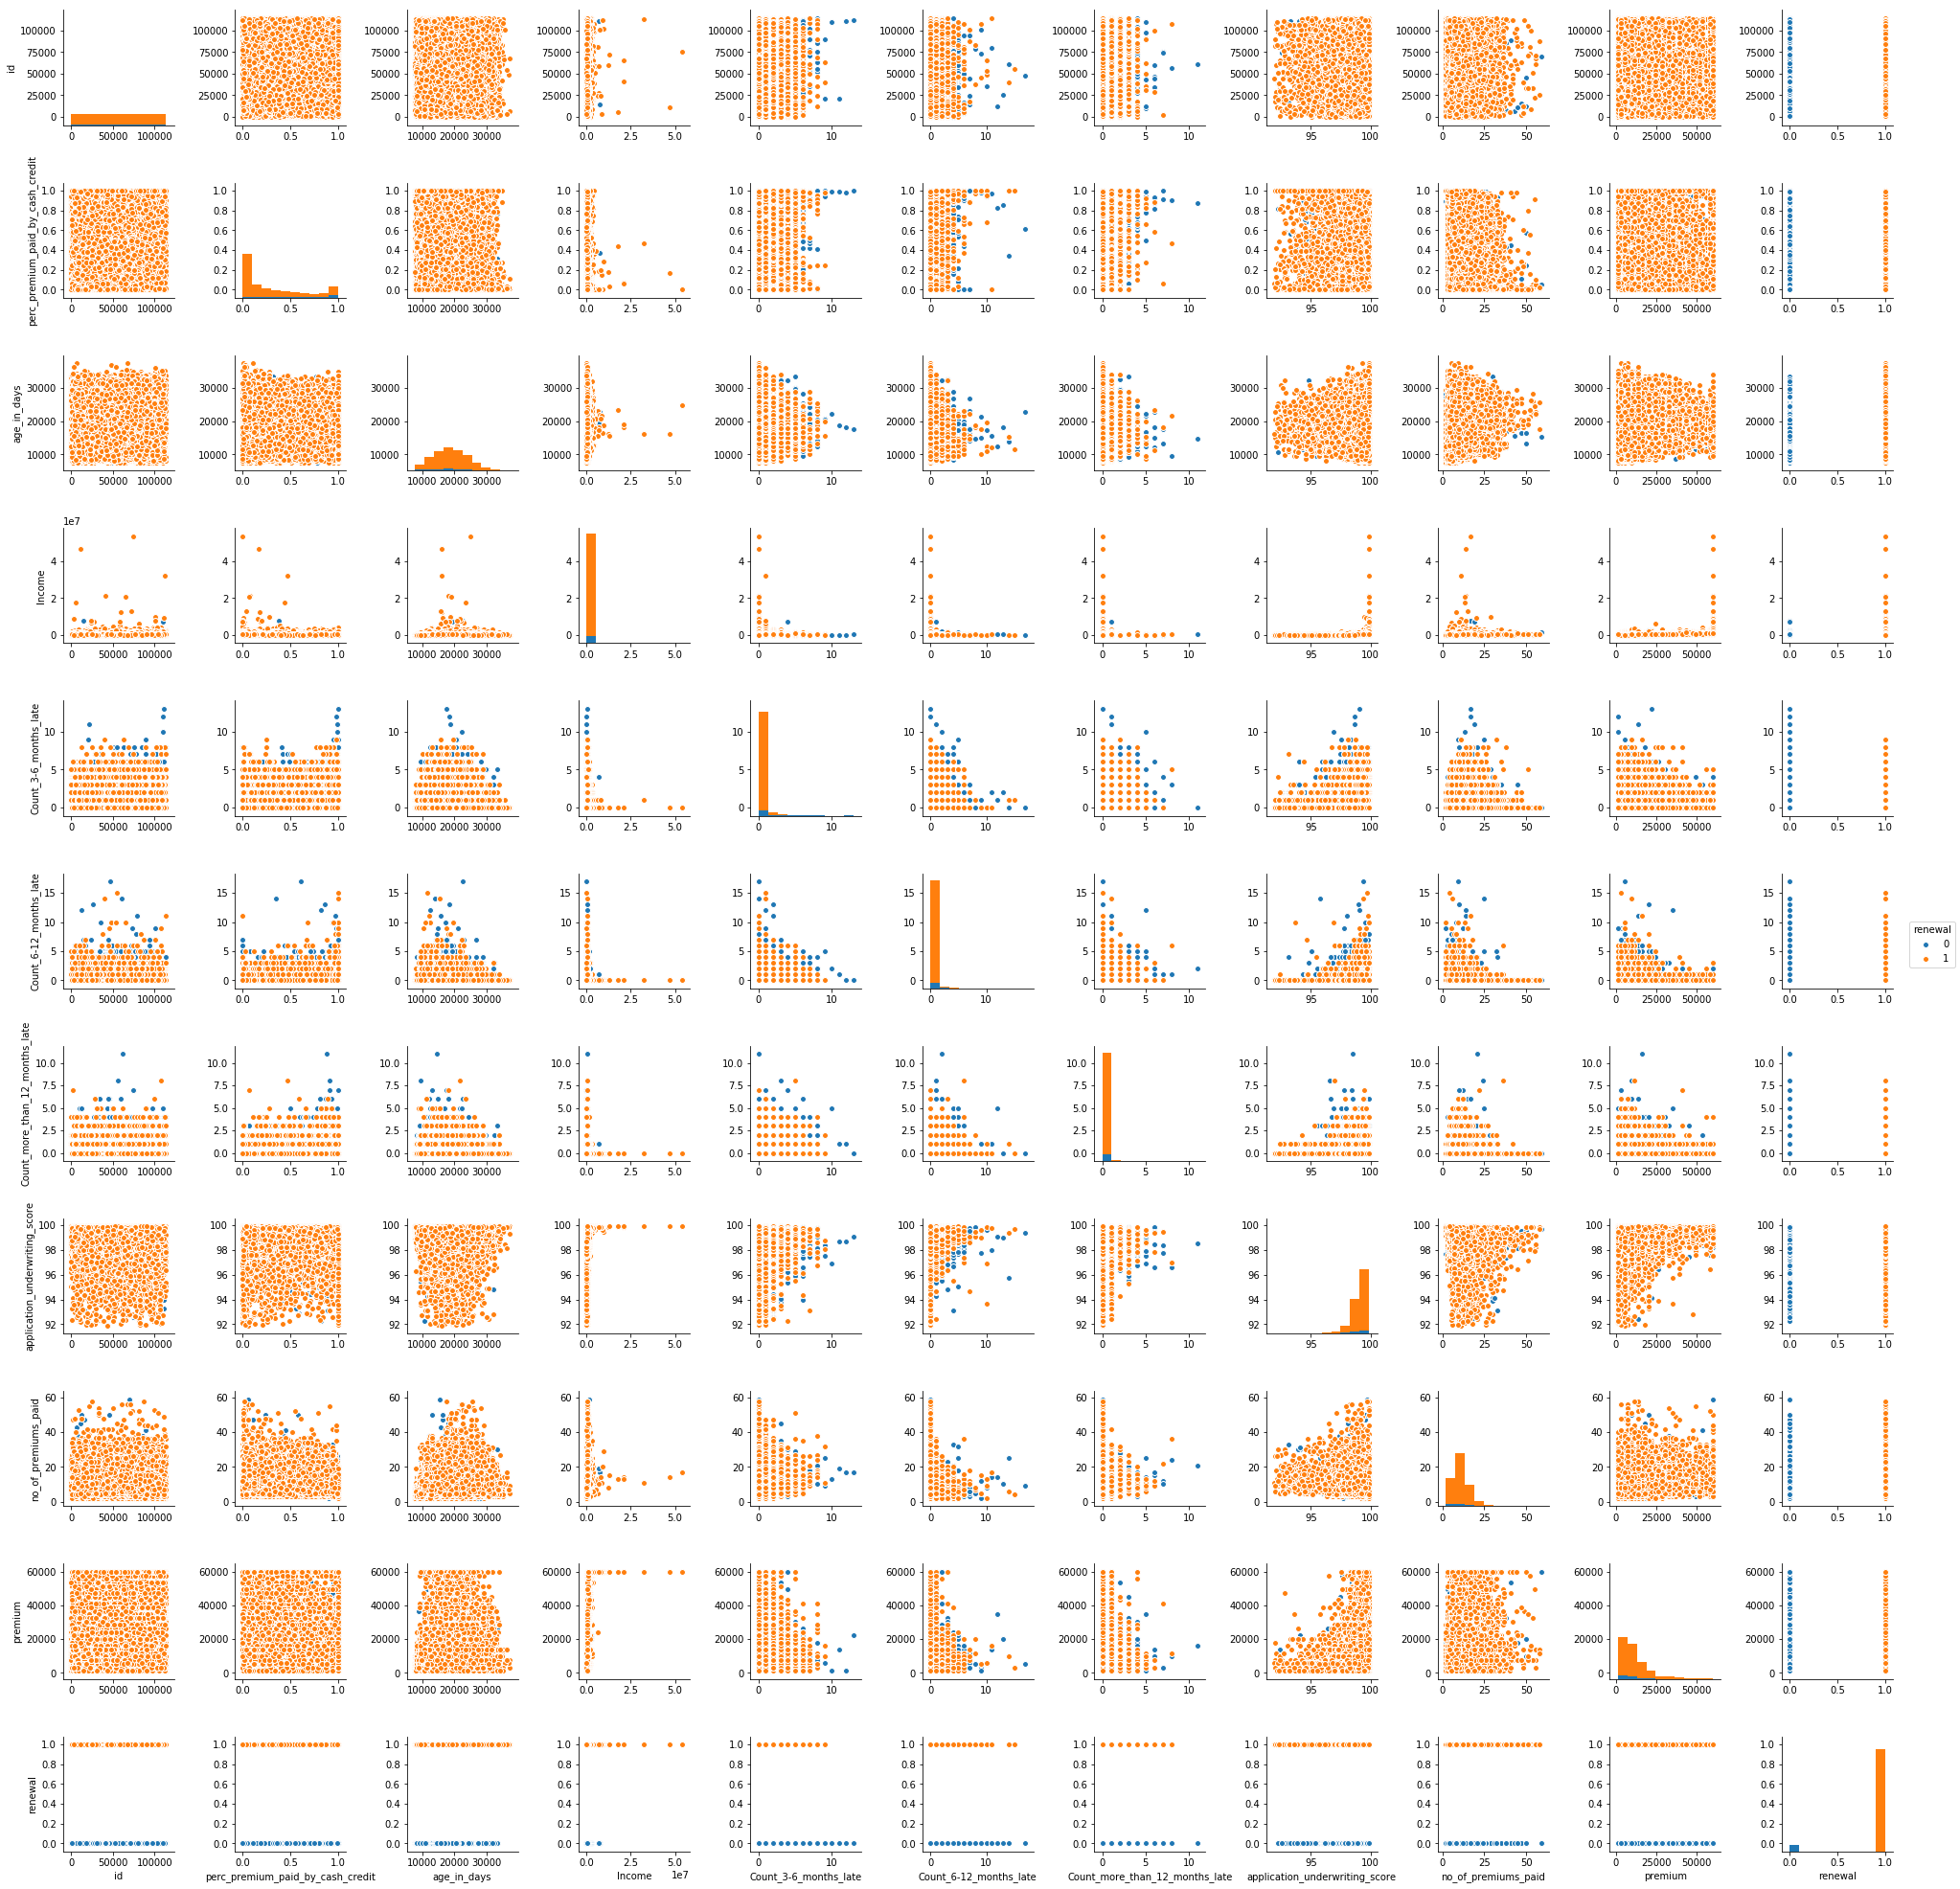

In [271]:
# just for reference, don't expect there to be much here...
ax = sns.pairplot(df, hue = 'renewal')

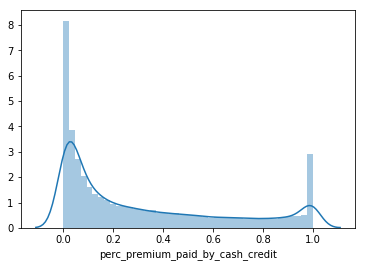

In [272]:
############################
# perc_premium paid in cash:

ax = sns.distplot(a = df['perc_premium_paid_by_cash_credit'], kde = 1)


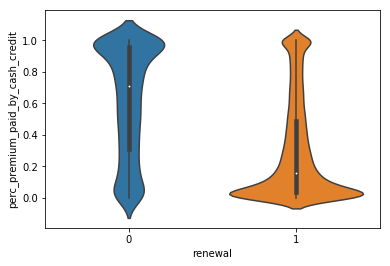

In [273]:
# violin plot it to see if hte distribution is bimodal or id anything else interesting is going on:

ax = sns.violinplot( x = 'renewal', y = 'perc_premium_paid_by_cash_credit', data = df )



It appears that individuals who renew paid tended to not pay with cash or credit card (check?) While a preponderance of individuals who didn't renew did pay by cash or credit

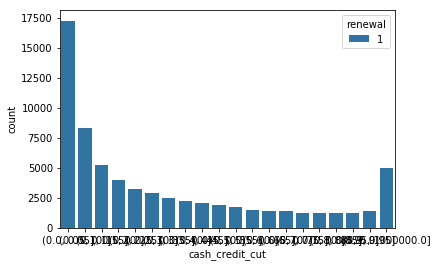

In [274]:
# Let's break this down into cuts of hte data:

df['cash_credit_cut'] = pd.cut(df['perc_premium_paid_by_cash_credit'], 
                               [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1e6], 19)


ax = sns.countplot( x = 'cash_credit_cut', hue = 'renewal' , data = df[df['renewal']==1] )


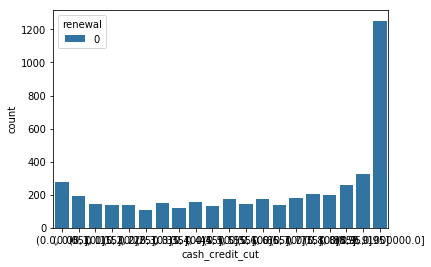

In [275]:
ax = sns.countplot( x = 'cash_credit_cut', hue = 'renewal' , data = df[df['renewal']==0] )

**Summary**: not the best way to visualize the plots, but proves the point...looks like this will be an important way of creating a linearly separable case for the model

In [276]:
############################
# age in days:

# first, we will (in roundabout fashion) convert to years to make more interpretable:

df['age_in_years']= df['age_in_days']*1.0000 / 365

print(df[['age_in_days', 'age_in_years']].head())

   age_in_days  age_in_years
0        12058     33.035616
1        21546     59.030137
2        17531     48.030137
3        15341     42.030137
4        31400     86.027397


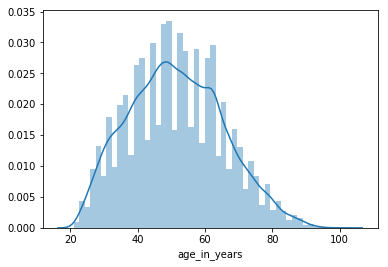

In [277]:
# plot distribution of the ages:

ax = sns.distplot(a = df['age_in_years'])

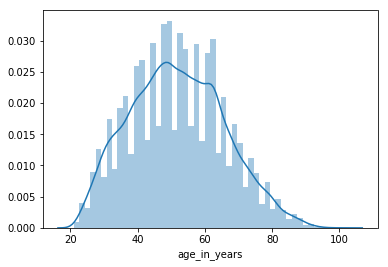

In [278]:
# look at each case separately:

ax = sns.distplot(a = df[df['renewal'] == 1 ]['age_in_years'])

# since 97% of the data is renewed, it makes sense that this looks the same

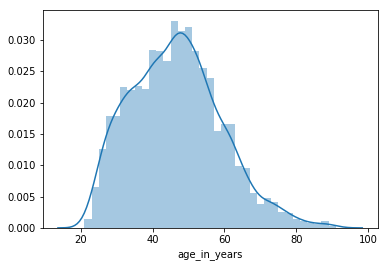

In [279]:
ax = sns.distplot(a = df[df['renewal'] == 0 ]['age_in_years'])

# still a positive skew, but with a little more concentration in the younger groupings

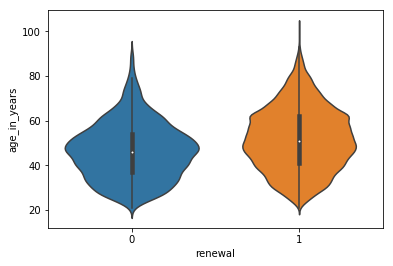

In [280]:
# look at them SxS:

ax = sns.violinplot(x = 'renewal', y = 'age_in_years', data = df )

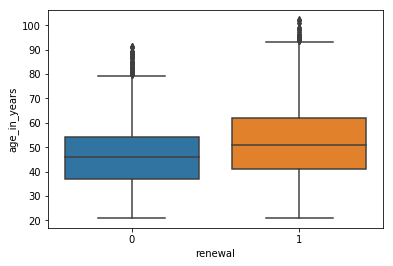

In [281]:
# boxplot:

ax = sns.boxplot(x = 'renewal', y= 'age_in_years', data = df)

**summary**: overall, there are really slight differences in the distributions of the 2 classes, this might be a less important variable in the model

In [282]:
############################
# income:

# remember, this is monthly in case the numbers look a little low (we could annualize for interpretability)

df['income_annual'] = df['Income'] * 12

df[['income_annual','Income']].head()


,income_annual,Income
0,4260720,355060
1,3781800,315150
2,1009680,84140
3,3006120,250510
4,2384160,198680


In [283]:
# Annual does not appear to matter since it looks like the data is masked or in a different currency than USD

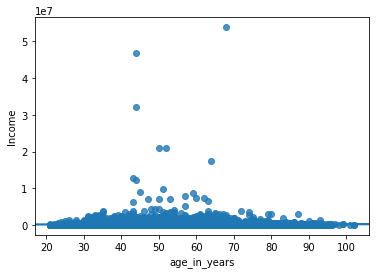

In [284]:
# plot the distribution:
# looks like outliers in the income range were impacting the ability to scatterplot the data, let's filter those out

ax = sns.regplot(x = df['age_in_years'], y = df['Income'])

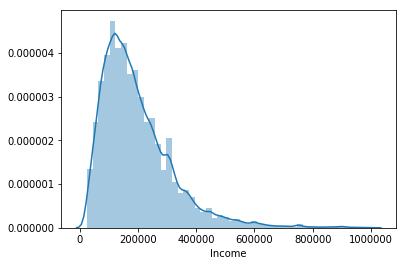

In [285]:
# < 1.000.000: 
ax = sns.distplot(a = df[df['Income'] <1000000]['Income'])



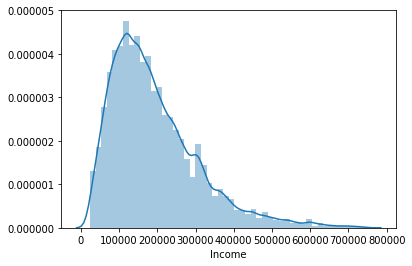

In [286]:
ax = sns.distplot(a = df[df['Income'] <750000]['Income'])

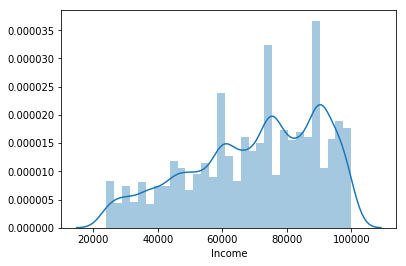

In [287]:
# being realistic:

ax = sns.distplot(a = df[df['Income'] <100000]['Income'])

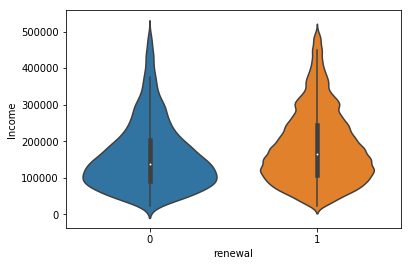

In [288]:
# do renewals occur more for lower or higher income:

ax = sns.violinplot(x = 'renewal', y = 'Income', data = df[df['Income'] < 500000])

With high level outlier filtering, it does appear that lower income renew slightly less than those who do - makes sense; very positive skew

46619


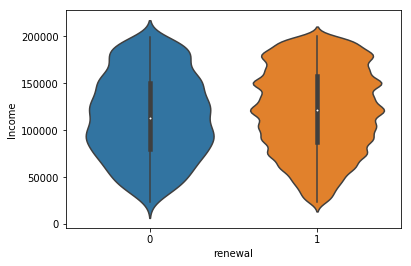

In [289]:
# filter lower:

print(df[df['Income'] < 200000].shape[0]) # 46,619; still plenty of records
ax = sns.violinplot(x = 'renewal', y = 'Income', data = df[df['Income'] < 200000])

renewals are still more positively skewed than the non-renewals ; this wouldn't pass a t-test

**Summary**: It appears that the income level may play a slightly influential role in the renewal rates for the policies; however, when filtering down to lower income levels the distributions start to overlap even more. That being said, we do notice that the non-renewal distribution becomes much more "normal" in shape.

In [290]:
############################
# Count_3-6_months_late :

print(df['Count_3-6_months_late'].describe())
print(df['Count_3-6_months_late'].median())
print(df['Count_3-6_months_late'].unique()) # looks like between 0 and 13 premiums are late for the 3-6 month range


count    76855.000000
mean         0.254388
std          0.699544
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: Count_3-6_months_late, dtype: float64
0.0
[  0.   2.   1.   3.   4.   7.   5.   6.   8.  13.  12.   9.  11.  10.]


In [291]:
# need to look at the percentage and counts by each group and layer in renewals:

print(df.groupby(by =['renewal', 'Count_3-6_months_late']).count() )

                                  id  perc_premium_paid_by_cash_credit  \
renewal Count_3-6_months_late                                            
0       0.0                     2498                              2498   
        1.0                     1138                              1138   
        2.0                      584                               584   
        3.0                      287                               287   
        4.0                      155                               155   
        5.0                       66                                66   
        6.0                       30                                30   
        7.0                       10                                10   
        8.0                        6                                 6   
        9.0                        2                                 2   
        10.0                       1                                 1   
        11.0                       1  

In [292]:
# over renewed customers who actually ever has an instance of lateness: 

total_renewals = df['renewal'][df['renewal'] >0].count()
total_3_6_late_on_renewals = df['renewal'][(df['renewal'] >0) & (df['Count_3-6_months_late'] >0)].count()


print('----------------------------------')
print('renewal late rate')
print(total_renewals)
print(total_3_6_late_on_renewals)

print(total_3_6_late_on_renewals / total_renewals ) # only 14% of renewals are ever actually late

total_nonrenewals = df['renewal'][df['renewal'] == 0].count()
total_3_6_late_on_nonrenewals = df['renewal'][(df['renewal'] == 0) & (df['Count_3-6_months_late'] >0)].count()


print('----------------------------------')
print('non-renewal late rate')

print(total_nonrenewals)
print(total_3_6_late_on_nonrenewals)

print(total_3_6_late_on_nonrenewals / total_nonrenewals ) # 47% of non-renewals experience at least one 3-6 month late payment

# 3 x more likely to have late 3-6 months

----------------------------------
renewal late rate
72075
10456
0.145071106486
----------------------------------
non-renewal late rate
4780
2282
0.477405857741


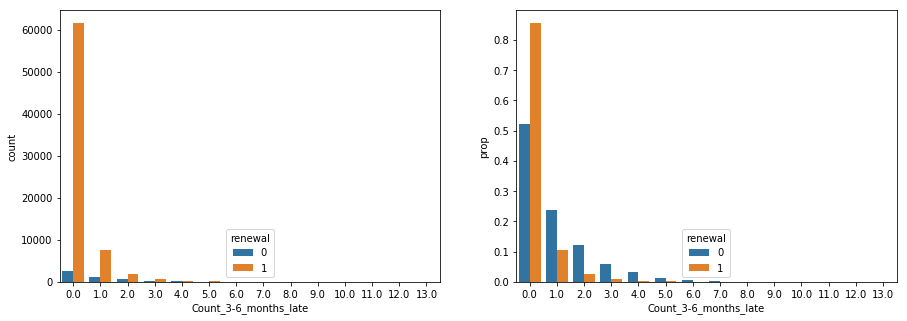

In [293]:
# want to see this as proportions
x, y, hue = 'Count_3-6_months_late', 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]


**Summary**: It looks like those who renew their policies tends to have a considerably lower proportion of customers who have 3-6 month late instances

It looks like those who don't have their policies renewed are nearly **3 X more likely** to have had a historic 3-6 month late payment at some point in their history

In [294]:
############################
# Count_6-12_months_late :

column = 'Count_6-12_months_late'

print(df[column].describe())
print(df[column].median())
print(df[column].unique()) # looks like between 0 and 17 premiums are late for the 6-12 month range


count    76855.000000
mean         0.076937
std          0.430994
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: Count_6-12_months_late, dtype: float64
0.0
[  0.   3.   6.   2.  10.   1.   4.   7.   5.  17.   9.  15.   8.  11.  14.
  13.  12.]


In [295]:
total_renewals = df['renewal'][df['renewal'] >0].count()
total_6_12_late_on_renewals = df['renewal'][(df['renewal'] >0) & (df[column] >0)].count()


print('----------------------------------')
print('renewal late rate')
print(total_renewals)
print(total_6_12_late_on_renewals)

print(total_6_12_late_on_renewals / total_renewals ) 

total_nonrenewals = df['renewal'][df['renewal'] == 0].count()
total_6_12_late_on_nonrenewals = df['renewal'][(df['renewal'] == 0) & (df[column] >0)].count() # 3%


print('----------------------------------')
print('non-renewal late rate')

print(total_nonrenewals)
print(total_6_12_late_on_nonrenewals)

print(total_6_12_late_on_nonrenewals / total_nonrenewals ) # 30% - so a drop, but much more likely to see this occur at least once


----------------------------------
renewal late rate
72075
2294
0.0318279569892
----------------------------------
non-renewal late rate
4780
1437
0.300627615063


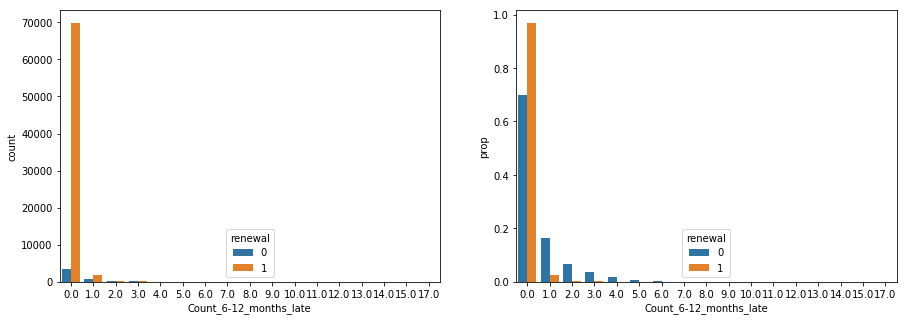

In [296]:
x, y, hue = column, 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]


**Summary** : it looks like we are even more likely to have an instance of 6-12 month late payments for those who don't renew.  While the overall proportion of the non-renewal population who were actually late declined to 30%, these individuals are 10X more likely to have a 6-12 month late payment than those who renewed

In [297]:
############################
# > 12 months late :

column = 'Count_more_than_12_months_late'

print(df[column].describe())
print(df[column].median())
print(df[column].unique()) # surprising that some folks can have this many late payments...


count    76855.000000
mean         0.061154
std          0.315304
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: Count_more_than_12_months_late, dtype: float64
0.0
[  0.   1.   4.   2.   3.   7.   5.  11.   6.   8.]


In [298]:
total_renewals = df['renewal'][df['renewal'] >0].count()
total_6_12_late_on_renewals = df['renewal'][(df['renewal'] >0) & (df[column] >0)].count()


print('----------------------------------')
print('renewal late rate')
print(total_renewals)
print(total_6_12_late_on_renewals)

print(total_6_12_late_on_renewals / total_renewals ) 

total_nonrenewals = df['renewal'][df['renewal'] == 0].count()
total_6_12_late_on_nonrenewals = df['renewal'][(df['renewal'] == 0) & (df[column] >0)].count() # 3%


print('----------------------------------')
print('non-renewal late rate')

print(total_nonrenewals)
print(total_6_12_late_on_nonrenewals)

print(total_6_12_late_on_nonrenewals / total_nonrenewals ) 

----------------------------------
renewal late rate
72075
2482
0.0344363510232
----------------------------------
non-renewal late rate
4780
1163
0.243305439331


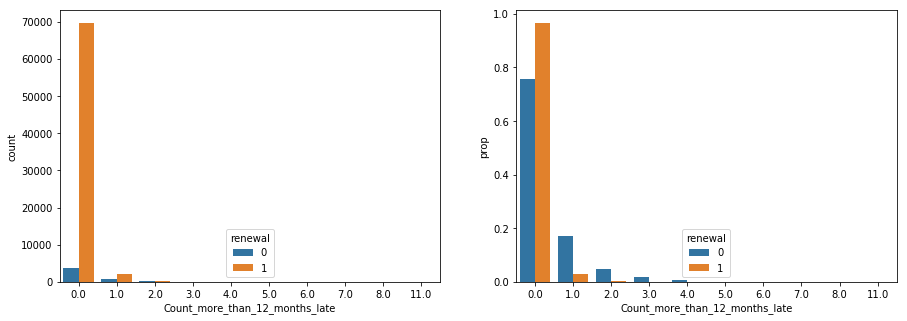

In [299]:
x, y, hue = column, 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]


** Summary ** : Continued decline in the number of renewals and non-renewals with this level of terdiness

In [300]:
############################
# Underwriting score :

column = 'application_underwriting_score'

print(df[column].describe())
print(df[column].median())
print(df[column].max() - df[column].min() )

count    76855.000000
mean        99.067053
std          0.739789
min         91.900000
25%         98.810000
50%         99.210000
75%         99.540000
max         99.890000
Name: application_underwriting_score, dtype: float64
99.21
7.99


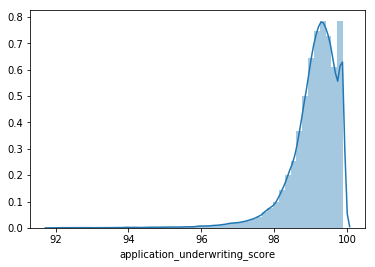

In [301]:
# Distribution:

ax = sns.distplot(a = df[column])

# distribution appears to be bi-modal- something to watch out for in modeling

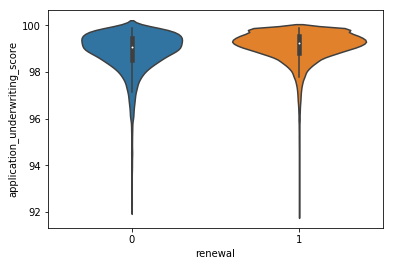

In [302]:
# is score indicative of renewal? 

ax = sns.violinplot(x = 'renewal', y = column, data = df)

the renewal distribution is a little more peaked, and the non-renewal is not bimodal. This suggests that there are some subtle differences in these 2 groups of applicants

In [303]:
############################
# no_of_premiums_paid :

column = 'no_of_premiums_paid'

print(df[column].describe())
print(df[column].median())
print(df[column].max() - df[column].min() )

count    76855.000000
mean        11.054505
std          5.106978
min          2.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         59.000000
Name: no_of_premiums_paid, dtype: float64
10.0
57


This could be indiciative of the time open and could be collinear with some of the other variables already in the dataframe

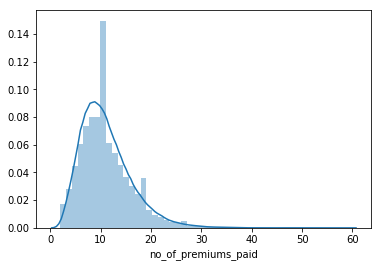

In [304]:
ax = sns.distplot(a = df[column])

Looks like there are big spikes around 12 and 18 - probably term lengths or something of that nature

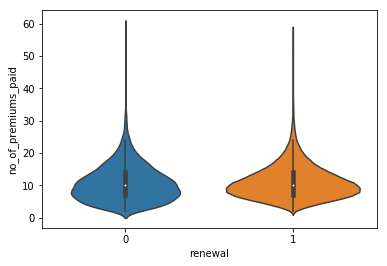

In [305]:
ax = sns.violinplot(x= 'renewal', y = column, data = df )

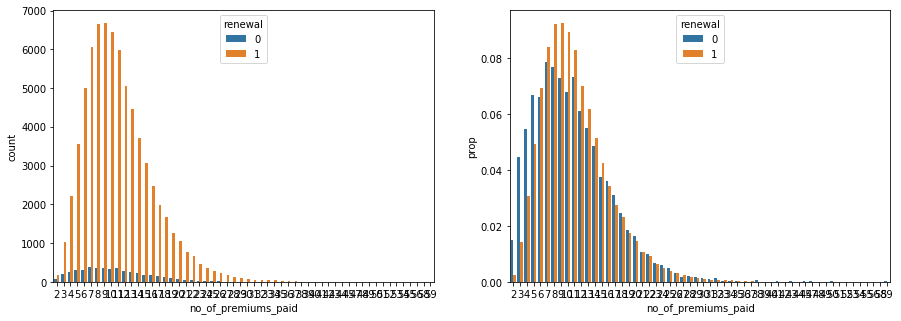

In [306]:
x, y, hue = column, 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]

**Summary** : We notice a bit of the same thing that we noticed previously regarding the breakdowns

In [307]:
############################
# sourcing channel :

column = 'sourcing_channel'

print(df[column].describe())


count     76855
unique        5
top           A
freq      40909
Name: sourcing_channel, dtype: object


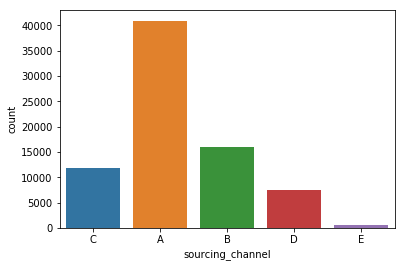

In [308]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sns.countplot(x = column, data =df)

The overwhelming majority of cases fall into the "A" sourcing channel

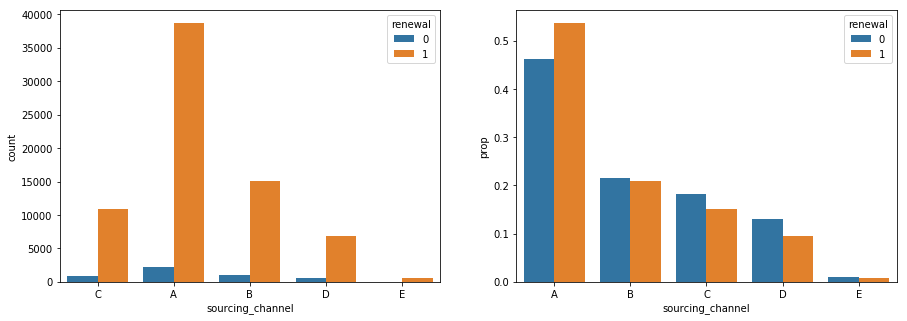

In [309]:
# which sourcing channels renew the most?

x, y, hue = column, 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]

it looks like we do see a proportional shift in all categories but A.  This might not be meaningful at all.

In [310]:
############################
# residance type :

column = 'residence_area_type'

print(df[column].describe())

count     76855
unique        2
top       Urban
freq      46328
Name: residence_area_type, dtype: object


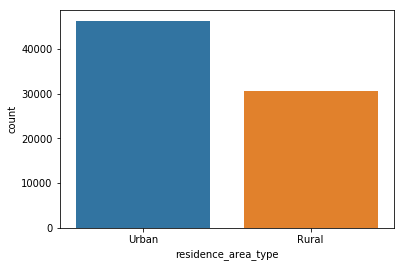

In [311]:
plt.rcParams['figure.figsize'] = [6, 4]
ax = sns.countplot(x = column, data =df)

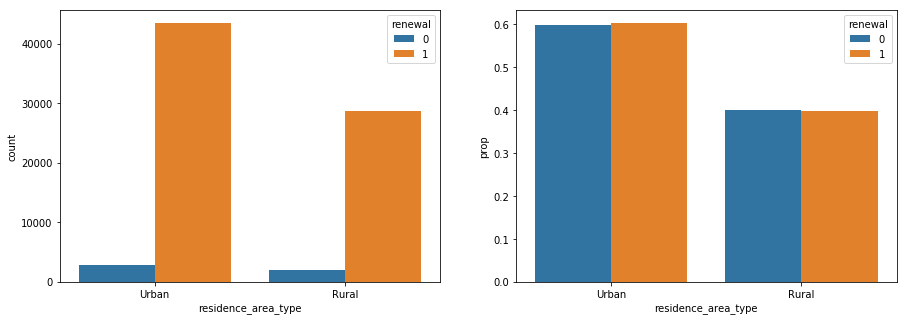

In [312]:
# which sourcing channels renew the most?

x, y, hue = column, 'prop', 'renewal'

#plt.rcParams - print plt params
#plt.rcParams['figure.figsize'] -- need to update the figure sizes

plt.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(1, 2)
ax = sns.countplot(x=x, hue=hue, data=df, ax=axes[0])

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

ax = sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

plt.rcParams['figure.figsize'] = [6, 4]

Most of the Customers are Urban and we see that rural Customers a somewhat less likely to renew

In [313]:
############################
# Premium paid :

column = 'premium'

print(df[column].describe())
print(df[column].median())
print(df[column].max() - df[column].min() )

count    76855.000000
mean     11007.937024
std       9419.183801
min       1200.000000
25%       5400.000000
50%       7500.000000
75%      13800.000000
max      60000.000000
Name: premium, dtype: float64
7500.0
58800


Once again, maybe not in USD as these do seem pretty high

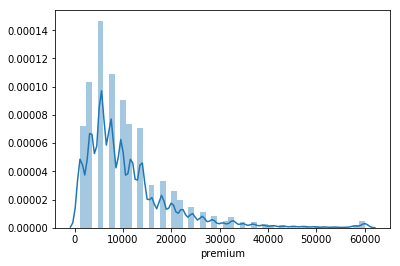

In [314]:
# let's look at the distribution:

ax = sns.distplot(a = df[column])

highly positively skewed distribution

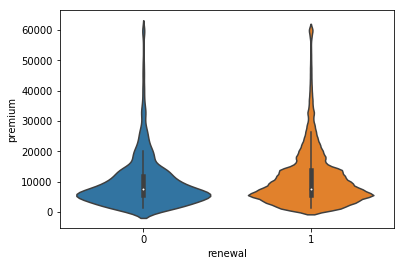

In [315]:
# analyze the differences in premium versus renewal rate:

ax = sns.violinplot(x= 'renewal',y = column, data =df )

looks like a slightly higher premium may impact the liklihood of renewal

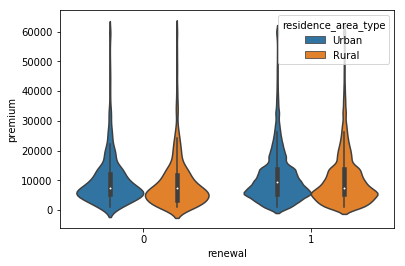

In [316]:
ax = sns.violinplot(x= 'renewal',y = column, hue = 'residence_area_type',  data =df )

interesting, although slight, urban renewals look to be a little higher than rural, but they are nearly equal in the non-renewal

# Part A Solution section

In [317]:
# Let's try a few different algorithms to see what we can come up with 


# set a baseline with logistic regression:
# cross-validation: stratified k-folds
# problem type: binary classification

# we will also need to one-hot encode the variables in order to appropriately train the models

# Y-variable: no class transformtions are needed on the y-variable as it is already in the correct format - no use of labelencoder


In [319]:
# list out the variable names for reference:

print(list(df)) # print to take up less space

['id', 'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type', 'premium', 'renewal', 'cash_credit_cut', 'age_in_years', 'income_annual']


In [320]:
# remove our variable that we created:

df = df.drop(['cash_credit_cut'], axis = 1)

In [321]:
# 2 columns need to be one-hot encoded: sourcing channel and residence type:

channel = pd.get_dummies(df['sourcing_channel'], prefix = 'channel') # reference category will be group A
residence_type = pd.get_dummies(df['residence_area_type'], prefix = 'rural') # reference category will be Urban


one_hot_df = pd.concat([channel, residence_type], axis = 1)
df = pd.concat([df, one_hot_df], axis = 1) # just like this approach better - see the steps
df.head() # just so we can take a peak at the columns


,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,...,renewal,age_in_years,income_annual,channel_A,channel_B,channel_C,channel_D,channel_E,rural_Rural,rural_Urban
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,...,1,33.035616,4260720,0,0,1,0,0,0,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,...,1,59.030137,3781800,1,0,0,0,0,0,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,...,0,48.030137,1009680,0,0,1,0,0,1,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,...,1,42.030137,3006120,1,0,0,0,0,0,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,...,1,86.027397,2384160,0,1,0,0,0,0,1


In [324]:
# now, we need to remove the old columns, the reference categories, and the ones we will not use in the modeling:

df = df.drop(['id','sourcing_channel', 'residence_area_type', 'channel_A','rural_Urban'], axis = 1)

In [325]:
# spot check:
df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal,age_in_years,income_annual,channel_B,channel_C,channel_D,channel_E,rural_Rural
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,1,33.035616,4260720,0,1,0,0,0
1,0.010,21546,315150,0.0,0.0,0.0,99.89,21,18000,1,59.030137,3781800,0,0,0,0,0
2,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0,48.030137,1009680,0,1,0,0,1
3,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,1,42.030137,3006120,0,0,0,0,0
4,0.052,31400,198680,0.0,0.0,0.0,99.87,12,9600,1,86.027397,2384160,1,0,0,0,0


In [326]:
# separate the X and Y variables:

Y = df['renewal']
X = df.drop(['renewal'], axis = 1) # keeping all variables in to start

In [327]:
# we will separate out the data into a training and test BUT this test set is really the validation set since we will be using k-fold cross val

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 9991, stratify = Y )


In [328]:
# test stratification results:

print(y_train.sum() / len(y_train))
print(y_test.sum() / len(y_test))

0.9378045077997369
0.9378090033827738


In [330]:
# transform the x data:

scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train) # scale based on the training set
X_test_scl = scl.transform(X_test)

# create arrays for the y variables:

y_train = np.array(y_train)
y_test = np.array(y_test)


##### Model 1: Naive approach - use one variable to predict renewals

**Model**:logistic regression (naive)

**Features**: perc_premium_paid_by_cash_credit

**Tuning**: using the cvgridsearch iterator

**Cross validation**: using a gridsearch to solve for learning rate and normalization scheme; gridsearch cv incorporates a stratified k-fold approach - using 10 folds (per: Ron Kohavi)

In [353]:
%%time

# naive logistic regression

# variables to change in model:

cv = 10 # stratified samples

estimator = LogisticRegression (n_jobs = 1)

param_grid = [{'penalty': ['l1'], 'C': [0.1, 0.3, 0.5, 1.0, 2.0, 3]},
              {'penalty': ['l2'], 'C': [0.1, 0.3, 0.5, 1.0, 2.0, 3]}]

scorers = ['accuracy', 'roc_auc', 'precision','recall']

# instantiate a result for each scorer:

cv_results = []

# loop for going through scores
for score in scorers:
    reg = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = cv, scoring = score, return_train_score= True)
    reg.fit(X_train_scl, y_train)
    cv_results.append(reg.cv_results_)
    print('the best parameters solving for', score, 'are: ', reg.best_params_, ' With a score of: ', reg.best_score_)
    

the best parameters solving for accuracy are:  {'C': 0.3, 'penalty': 'l1'}  With a score of:  0.940002024028
the best parameters solving for roc_auc are:  {'C': 0.1, 'penalty': 'l1'}  With a score of:  0.829488049666
the best parameters solving for precision are:  {'C': 0.3, 'penalty': 'l1'}  With a score of:  0.945356424607
the best parameters solving for recall are:  {'C': 0.1, 'penalty': 'l1'}  With a score of:  0.993478944161
Wall time: 1min 38s


In [355]:
pd.DataFrame(cv_results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,"[0.12841398716, 0.135697412491, 0.149965167046...","[0.00070526599884, 0.000598359107971, 0.000496...","[0.939973109341, 0.940002024028, 0.93998756668...","[0.940059852946, 0.940034150986, 0.94003093826...","[0.1, 0.3, 0.5, 1.0, 2.0, 3, 0.1, 0.3, 0.5, 1....","[l1, l1, l1, l1, l1, l1, l2, l2, l2, l2, l2, l2]","[{'C': 0.1, 'penalty': 'l1'}, {'C': 0.3, 'pena...","[8, 1, 2, 2, 2, 8, 2, 2, 2, 8, 8, 8]","[0.939144261347, 0.939144261347, 0.93914426134...","[0.94016160383, 0.940097347834, 0.940081283835...",...,"[0.937825332562, 0.937825332562, 0.93782533256...","[0.940275970636, 0.940211716704, 0.94021171670...","[0.938837478311, 0.938982070561, 0.93883747831...","[0.94024384367, 0.940227780187, 0.940227780187...","[0.938982070561, 0.938692886061, 0.93869288606...","[0.940195653222, 0.940195653222, 0.94019565322...","[0.00833505155478, 0.00750349807084, 0.0381811...","[0.000462179682045, 0.000488558321927, 0.00049...","[0.00172478168602, 0.00176944603507, 0.0017782...","[0.000203604052893, 0.000212998716533, 0.00021..."
1,"[0.130622768402, 0.134937500954, 0.15476219654...","[0.00139639377594, 0.00169537067413, 0.0016899...","[0.829488049666, 0.829347210121, 0.82932495407...","[0.830224823566, 0.830132317409, 0.83011096343...","[0.1, 0.3, 0.5, 1.0, 2.0, 3, 0.1, 0.3, 0.5, 1....","[l1, l1, l1, l1, l1, l1, l2, l2, l2, l2, l2, l2]","[{'C': 0.1, 'penalty': 'l1'}, {'C': 0.3, 'pena...","[1, 4, 6, 7, 9, 12, 2, 3, 5, 8, 10, 11]","[0.828227935435, 0.828183942398, 0.82818930740...","[0.830544130957, 0.830467299777, 0.83045028124...",...,"[0.834204261056, 0.834196372867, 0.83416625433...","[0.830235722847, 0.830153276935, 0.83013341860...","[0.829629111718, 0.829682536268, 0.82968934879...","[0.830179585131, 0.830098877762, 0.83007950162...","[0.82507260719, 0.82486500441, 0.824831658886,...","[0.830361468678, 0.83027626233, 0.830257417044...","[0.0111610100507, 0.011246215888, 0.0515761451...","[0.000489418310169, 0.000456991356908, 0.00045...","[0.00829408631739, 0.00837650937653, 0.0083923...","[0.000874123186493, 0.000872139897609, 0.00087..."
2,"[0.138845825195, 0.146684455872, 0.14850130081...","[0.00129675865173, 0.00119273662567, 0.0015898...","[0.94530255292, 0.945356424607, 0.945355630442...","[0.945327546168, 0.945333378064, 0.94533610131...","[0.1, 0.3, 0.5, 1.0, 2.0, 3, 0.1, 0.3, 0.5, 1....","[l1, l1, l1, l1, l1, l1, l2, l2, l2, l2, l2, l2]","[{'C': 0.1, 'penalty': 'l1'}, {'C': 0.3, 'pena...","[12, 1, 2, 2, 2, 8, 7, 2, 2, 8, 8, 8]","[0.944851862716, 0.944982394366, 0.94498239436...","[0.945428762367, 0.945410683141, 0.94539527302...",...,"[0.944509688784, 0.944509688784, 0.94450968878...","[0.945566586785, 0.945563036992, 0.94556303699...","[0.945874393293, 0.946013533392, 0.94600559070...","[0.945361513517, 0.945360623146, 0.94536062314...","[0.944966245964, 0.94495008808, 0.94495008808,...","[0.945402392516, 0.945416911142, 0.94541691114...","[0.0149234541114, 0.045482319843, 0.0541465100...","[0.000456954954458, 0.000393278034302, 0.00049...","[0.00118313542718, 0.00120767366278, 0.0012072...","[0.000179649217081, 0.000182373183732, 0.00017..."
3,"[0.13229341507, 0.128709316254, 0.132994842529...","[0.00109689235687, 0.00109746456146, 0.0013916...","[0.993478944161, 0.993448112527, 0.99343269671...","[0.993545767672, 0.993509796626, 0.99350294496...","[0.1, 0.3, 0.5, 1.0, 2.0, 3, 0.1, 0.3, 0.5, 1....","[l1, l1, l1, l1, l1, l1, l2, l2, l2, l2, l2, l2]","[{'C': 0.1, 'penalty': 'l1'}, {'C': 0.3, 'pena...","[1, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]","[0.993063049175, 0.992908894713, 0.99290889471...","[0.99354230901, 0.993490921548, 0.993490921548...",...,"[0.991982732038, 0.991982732038, 0.99198273203...","[0.993508161902

list